Earlier this year [Axel asked](https://github.com/rdkit/rdkit/discussions/5102) about the differences 
in PMI (princile moments of inertia) values between different stereoisomers of the same molecule.
I guessed, but wasn't sure, that the differences arising from different stereoisomers would be small relative to those arising from inter-conformer variability in the structure.

This post looks into that question.

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import numpy as np
import rdkit
print(rdkit.__version__)
%pylab inline

2022.03.2
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Start by reading in 50 molecules from the [platinum dataset](https://doi.org/10.1021/acs.jcim.6b00613) 
which have at least one chiral center.

Note that as of the 
2022.03.3 release of the RDKit
the explicit call to `AssignStereochemistryFrom3D()` is no longer necessary for molecules which have 3D conformers. We changed the default behavior so that this function is called whenever a molecule has a 3D conformer.

In [2]:
with Chem.SDMolSupplier('../data/platinum_dataset_2017_01.sdf',removeHs=False) as suppl:
    ms = []
    while len(ms)<50:
        m = next(suppl)
        if not m:
            continue
        Chem.AssignStereochemistryFrom3D(m)
        if len(Chem.FindMolChiralCenters(m))<1:
            continue
        ms.append(m)

Look at the number of chiral centers present in each molecule

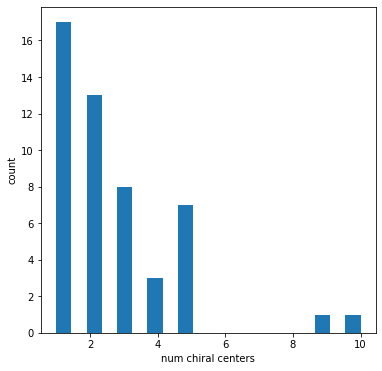

In [3]:
figsize(6,6)
hist([len(Chem.FindPotentialStereo(m)) for m in ms],bins=20);
xlabel('num chiral centers')
ylabel('count');

# inter-conformer variability for a single stereoisomer

Start by generating 100 conformers for each of our molecules.

We will only generate conformers which match the stereochemistry of the input structure (this is the default RDKit behavior).

In [4]:
ps = rdDistGeom.srETKDGv3()
ps.numThreads = 6
ps.randomSeed = 0xf00d
ps.pruneRmsThresh = 0.5

for m in ms:
    rdDistGeom.EmbedMultipleConfs(m,100,ps)

Generate the three PMI descriptors for each conformer of each molecule (note that PMI1 is the *smallest* principle moment).

In [5]:
accum = []
for m in ms:
    confs = m.GetConformers()
    d = []
    for conf in confs:
        d.append((rdMolDescriptors.CalcPMI1(m,confId=conf.GetId()),
        rdMolDescriptors.CalcPMI2(m,confId=conf.GetId()),
        rdMolDescriptors.CalcPMI3(m,confId=conf.GetId())))
    accum.append(np.array(d))

Look at the inter-conformer variability, as measured by the relative standard deviation, of the three descriptors

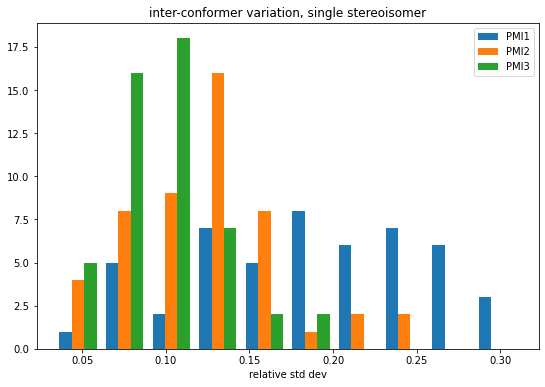

In [6]:
figsize(9,6)
means = np.array([np.average(mat,axis=0) for mat in accum])
stds = np.array([np.std(mat,axis=0) for mat in accum])
rel_stds = stds/means
hist(rel_stds,bins=10,label=('PMI1','PMI2','PMI3'));
legend();
title('inter-conformer variation, single stereoisomer')
xlabel('relative std dev');

And let's look at the standard deviations themselves:

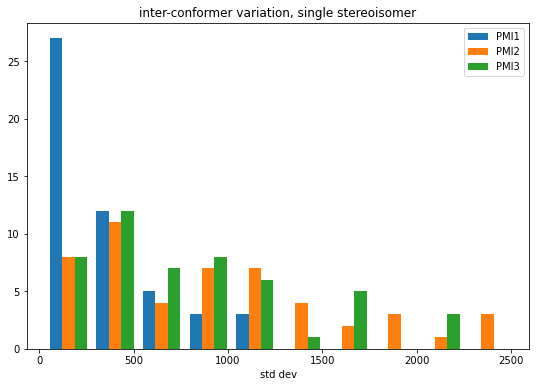

In [7]:
figsize(9,6)
hist(stds,bins=10,label=('PMI1','PMI2','PMI3'));
legend();
title('inter-conformer variation, single stereoisomer')
xlabel('std dev');

# Variability across conformers and stereoisomers

In [8]:
m2s = [Chem.Mol(m) for m in ms]

In [9]:
ps = rdDistGeom.srETKDGv3()
ps.numThreads = 6
ps.randomSeed = 0xf00d
ps.pruneRmsThresh = 0.5
ps.enforceChirality = False

for m in m2s:
    rdDistGeom.EmbedMultipleConfs(m,100,ps)

In [10]:
accum2 = []
for m in m2s:
    confs = m.GetConformers()
    d = []
    for conf in confs:
        d.append((rdMolDescriptors.CalcPMI1(m,confId=conf.GetId()),
        rdMolDescriptors.CalcPMI2(m,confId=conf.GetId()),
        rdMolDescriptors.CalcPMI3(m,confId=conf.GetId())))
    accum2.append(np.array(d))

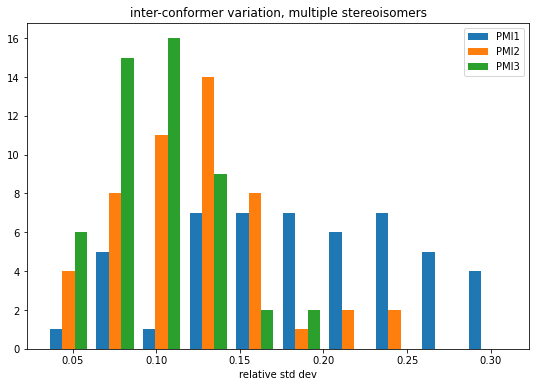

In [11]:
figsize(9,6)
means2 = np.array([np.average(mat,axis=0) for mat in accum2])
stds2 = np.array([np.std(mat,axis=0) for mat in accum2])
rel_stds2 = stds2/means2
hist(rel_stds2,bins=10,label=('PMI1','PMI2','PMI3'));
legend();
title('inter-conformer variation, multiple stereoisomers')
xlabel('relative std dev');

# Compare the single stereisomer variability to the multiple stereoisomer variability

First make sure that the means don't actually change

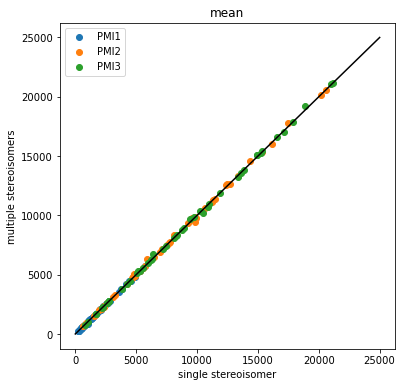

In [12]:
figsize(6,6)
scatter((means)[:,0],(means2)[:,0],label='PMI1');
scatter((means)[:,1],(means2)[:,1],label='PMI2');
scatter((means)[:,2],(means2)[:,2],label='PMI3');

ylabel('multiple stereoisomers')
xlabel('single stereoisomer');
title('mean')
legend()
plot((0,25000),(0,25000),'k');


That looks good

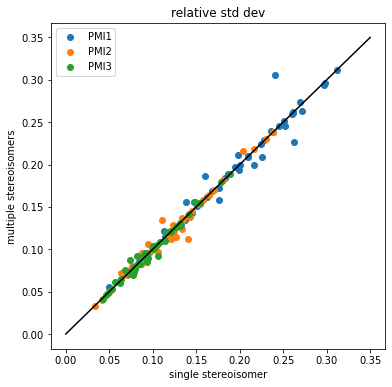

In [13]:
figsize(6,6)

scatter((stds/means)[:,0],(stds2/means2)[:,0],label='PMI1');
scatter((stds/means)[:,1],(stds2/means2)[:,1],label='PMI2');
scatter((stds/means)[:,2],(stds2/means2)[:,2],label='PMI3');

ylabel('multiple stereoisomers')
xlabel('single stereoisomer');
title('relative std dev')
legend()
plot((0,0.35),(0,0.35),'k');


So, at least for this set of 50 molecules, it looks like the answer to Axel's question is that the differences in PMI which arise from differing stereoisomers are small relative to the differences between conformers.

Let's still dig into the results a little bit. Which molecule(s) have the highest deviation for each of the moments?

In [14]:
indices = (argmax((stds2/means2)[:,0]-(stds/means)[:,0]),\
argmax((stds2/means2)[:,1]-(stds/means)[:,1]),\
argmax((stds2/means2)[:,2]-(stds/means)[:,2]))
indices

(13, 13, 37)

Let's look at those two molecules

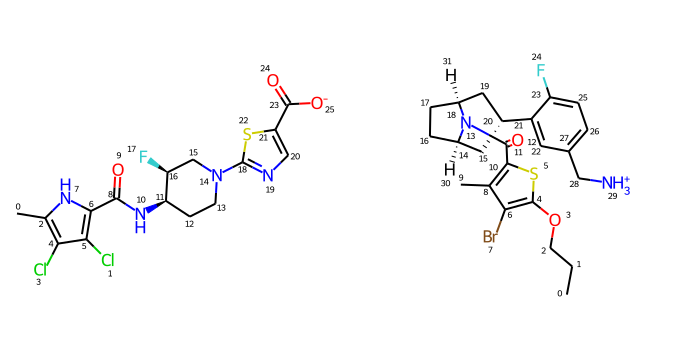

In [15]:
IPythonConsole.molSize = 350,350
IPythonConsole.drawOptions.addAtomIndices = True

maxdevs = [Chem.RemoveHs(Chem.Mol(ms[x])) for x in (13,37)]
for md in maxdevs:
           rdDepictor.Compute2DCoords(md)
Draw.MolsToGridImage(maxdevs,subImgSize=(350,350),molsPerRow=2)

Just to be sure, check which atoms can be stereo:

In [16]:
Chem.AssignStereochemistry(maxdevs[0],force=True,flagPossibleStereoCenters=True)
for atom in maxdevs[0].GetAtoms():
    if atom.HasProp('_ChiralityPossible'):
        print(atom.GetIdx())

11
16


Look at one of the conformers:

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

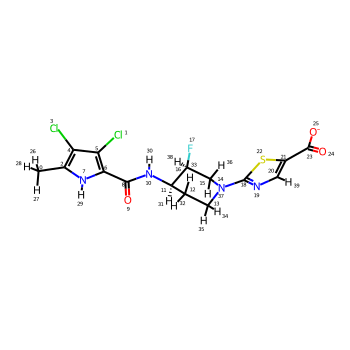

In [17]:
IPythonConsole.ipython_3d = True
ms[13]